In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
sp500 = pd.read_excel('1613615-Stock_Price_data_set.xlsx')

In [3]:
sp500

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100.0
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800.0
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500.0
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700.0
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900.0
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500.0
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300.0
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000.0
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200.0


In [4]:
sp500.set_index("Date", inplace=True)
del sp500["Adj Close"]
sp500

,Open,High,Low,Close,Volume
Date,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,11896100.0
2018-02-06,247.699997,266.700012,245.000000,265.720001,12595800.0
2018-02-07,266.579987,272.450012,264.329987,264.559998,8981500.0
2018-02-08,267.079987,267.619995,250.000000,250.100006,9306700.0
2018-02-09,253.850006,255.800003,236.110001,249.470001,16906900.0
...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,20047500.0
2022-02-01,432.959991,458.480011,425.540009,457.130005,22542300.0
2022-02-02,448.250000,451.980011,426.480011,429.480011,14346000.0


<AxesSubplot:xlabel='Date'>

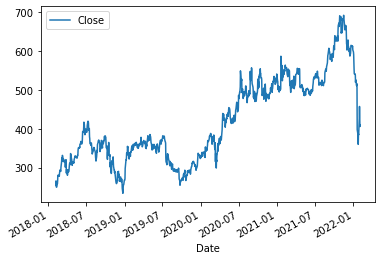

In [5]:
sp500.plot.line(y="Close", use_index=True)

In [6]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [7]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [9]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,11896100.0,265.720001,1
2018-02-06,247.699997,266.700012,245.000000,265.720001,12595800.0,264.559998,0
2018-02-07,266.579987,272.450012,264.329987,264.559998,8981500.0,250.100006,0
2018-02-08,267.079987,267.619995,250.000000,250.100006,9306700.0,249.470001,0
2018-02-09,253.850006,255.800003,236.110001,249.470001,16906900.0,257.950012,1
...,...,...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,20047500.0,457.130005,1
2022-02-01,432.959991,458.480011,425.540009,457.130005,22542300.0,429.480011,0
2022-02-02,448.250000,451.980011,426.480011,429.480011,14346000.0,405.600006,0


In [10]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [11]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.4117647058823529

<AxesSubplot:xlabel='Date'>

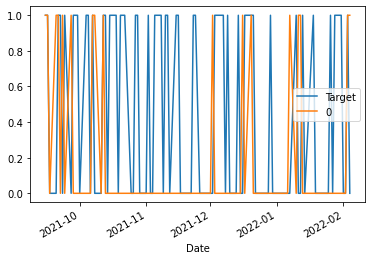

In [12]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [13]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [24]:
def backtest(data, model, predictors, start=500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [25]:
predictions = backtest(sp500, model, predictors)

In [26]:
predictions["Predictions"].value_counts()

0    453
1     56
Name: Predictions, dtype: int64

In [27]:
precision_score(predictions["Target"], predictions["Predictions"])


0.6607142857142857

In [28]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.518664
0    0.481336
Name: Target, dtype: float64